#### Import Necessary Libraries

In [136]:
import copy
from tqdm import tqdm
from datetime import timedelta

import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)

import matplotlib.pyplot as plt

### Load Data

In [555]:
DATE = '09-02-2025-NOON'
CRYPTO_PAIRS = ['BTCUSDT', 'ETHUSDT']
TICK_SIZES = { crypto_pair: 1e-2 for crypto_pair in CRYPTO_PAIRS }
LOT_SIZES = { 'BTCUSDT': 1e-5, 'ETHUSDT': 1e-4 }
ODB_DEPTH = 10

In [556]:
# load data csv
data = {
    'DEPTH': { crypto_pair: pd.read_csv(f"../data/{DATE}/BINANCE-{crypto_pair}-DEPTH.csv") for crypto_pair in tqdm(CRYPTO_PAIRS) },
    'TRADE': { crypto_pair: pd.read_csv(f"../data/{DATE}/BINANCE-{crypto_pair}-TRADES.csv") for crypto_pair in tqdm(CRYPTO_PAIRS) }
}

# convert time column to datetime timestamps and then move it to index
for crypto_pair in CRYPTO_PAIRS:

    # remove the unecessary columns
    data['DEPTH'][crypto_pair].drop('timestamp', axis=1, inplace=True)
    data['TRADE'][crypto_pair].drop(['timestamp', 'E'], axis=1, inplace=True)

    data['DEPTH'][crypto_pair].E = pd.to_datetime(data['DEPTH'][crypto_pair].loc[:, 'E'], unit='ms')
    data['TRADE'][crypto_pair].T = pd.to_datetime(data['TRADE'][crypto_pair].loc[:, 'T'], unit='ms')

    data['DEPTH'][crypto_pair].set_index('E', inplace=True)
    data['TRADE'][crypto_pair].set_index('T', inplace=True)

    # sort index to prevent any discrepency
    # kind='mergesort' is important as we want the original order intact in case of ties
    data['DEPTH'][crypto_pair].sort_index(kind='mergesort', inplace=True)
    data['TRADE'][crypto_pair].sort_index(kind='mergesort', inplace=True)

    data['DEPTH'][crypto_pair].index.name = 'timestamp'
    data['TRADE'][crypto_pair].index.name = 'timestamp'

100%|██████████| 2/2 [00:02<00:00,  1.20s/it]


In [557]:
data['DEPTH']['BTCUSDT']

,bp1,bp2,bp3,bp4,bp5,bp6,bp7,bp8,bp9,bp10,bv1,bv2,bv3,bv4,bv5,bv6,bv7,bv8,bv9,bv10,ap1,ap2,ap3,ap4,ap5,ap6,ap7,ap8,ap9,ap10,av1,av2,av3,av4,av5,av6,av7,av8,av9,av10
timestamp,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1970-01-01 00:00:00.000,96989.99,96989.98,96989.97,96989.96,96989.91,96989.90,96989.81,96989.80,96989.79,96989.78,10.69103,0.00018,0.00018,0.00018,0.00030,0.05862,0.00030,0.73024,0.00012,0.00012,96990.00,96990.30,96990.43,96990.46,96990.47,96990.66,96990.76,96990.84,96991.33,96991.34,20.50288,0.00029,0.00018,0.00030,0.00018,0.00018,0.00018,0.00018,0.00024,0.01057
2025-02-09 07:12:01.814,96989.99,96989.98,96989.97,96989.96,96989.91,96989.90,96989.81,96989.80,96989.79,96989.78,11.48073,0.00018,0.00018,0.00018,0.00030,0.05862,0.00030,0.73024,0.00012,0.00012,96990.00,96990.30,96990.43,96990.46,96990.47,96990.66,96990.76,96990.84,96991.33,96991.34,20.50288,0.00029,0.00018,0.00030,0.00018,0.00018,0.00018,0.00018,0.00024,0.01057
2025-02-09 07:12:01.914,96989.99,96989.98,96989.97,96989.96,96989.91,96989.90,96989.81,96989.80,96989.79,96989.78,11.48073,0.00018,0.00018,0.00018,0.00030,0.05862,0.00030,0.73024,0.00012,0.00012,96990.00,96990.30,96990.43,96990.46,96990.47,96990.66,96990.76,96990.84,96991.33,96991.34,20.50288,0.00029,0.00018,0.00030,0.00018,0.00018,0.00018,0.00018,0.00024,0.01057
2025-02-09 07:12:02.014,96989.99,96989.98,96989.97,96989.96,96989.91,96989.90,96989.81,96989.80,96989.79,96989.78,11.48073,0.00018,0.00018,0.00018,0.00030,0.05862,0.00030,0.73024,0.00012,0.00012,96990.00,96990.30,96990.43,96990.46,96990.47,96990.66,96990.76,96990.84,96991.33,96991.34,20.50288,0.00029,0.00018,0.00030,0.00018,0.00018,0.00018,0.00018,0.00024,0.01057
2025-02-09 07:12:02.114,96989.99,96989.98,96989.97,96989.96,96989.91,96989.90,96989.81,96989.80,96989.79,96989.78,11.47977,0.00018,0.00018,0.00018,0.00030,0.05862,0.00030,0.73024,0.00012,0.00012,96990.00,96990.30,96990.43,96990.46,96990.47,96990.66,96990.76,96990.84,96991.33,96991.34,20.48261,0.00029,0.00018,0.00030,0.00018,0.00018,0.00018,0.00018,0.00024,0.01057
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-02-10 01:29:51.014,96200.00,96199.93,96199.28,96199.22,96198.76,96198.75,96198.60,96198.21,96198.01,96198.00,10.35129,0.00037,0.00029,0.00025,0.00018,0.00018,0.00018,0.00029,0.00024,0.07152,96200.01,96200.35,96200.36,96200.37,96200.38,96200.56,96200.79,96201.12,96201.15,96201.53,6.21713,0.00018,0.24375,0.07359,0.00006,0.00006,0.00013,0.00772,0.06144,0.00006
2025-02-10 01:29:51.114,96200.00,96199.93,96199.28,96199.22,96198.76,96198.75,96198.60,96198.21,96198.01,96198.00,10.35129,0.00037,0.00029,0.00025,0.00018,0.00018,0.00018,0.00029,0.00024,0.07152,96200.01,96200.35,96200.36,96200.37,96200.38,96200.56,96200.79,96201.12,96201.15,96201.53,6.21720,0.00018,0.24375,0.07359,0.00006,0.00006,0.00013,0.00772,0.06144,0.00006
2025-02-10 01:29:51.214,96200.00,96199.93,96199.28,96199.22,96198.76,96198.75,96198.60,96198.21,96198.01,96198.00,10.35129,0.00037,0.00029,0.00025,0.00018,0.00018,0.00018,0.00029,0.00024,0.07152,96200.01,96200.35,96200.36,96200.37,96200.38,96200.56,96200.79,96201.12,96201.15,96201.53,6.21720,0.00018,0.24375,0.07359,0.00006,0.00006,0.00013,0.00761,0.06084,0.00006


In [558]:
data['TRADE']['BTCUSDT']

,p,q,mm_buy
timestamp,,,
2025-02-09 07:12:01.423,96990.00,0.00689,0
2025-02-09 07:12:01.502,96990.00,0.00013,0
2025-02-09 07:12:01.544,96990.00,0.00102,0
2025-02-09 07:12:01.544,96990.00,0.00009,0
2025-02-09 07:12:01.544,96990.00,0.00306,0
...,...,...,...
2025-02-10 01:30:33.416,96212.19,0.00006,0
2025-02-10 01:30:33.416,96212.19,0.00006,0
2025-02-10 01:30:33.577,96212.19,0.00233,1


In [559]:
for crypto_pair in tqdm(CRYPTO_PAIRS):
    # the first row requires syncing orderbook so the timestamp in it is `0` which is not valid. So, we simply drop it.
    data['DEPTH'][crypto_pair].drop(data['DEPTH'][crypto_pair].index[:1], inplace=True)
    # only keep the trades that happen between the first and last timestamp in the depth dataframe
    data['TRADE'][crypto_pair] = data['TRADE'][crypto_pair][np.logical_and(data['TRADE'][crypto_pair].index >= data['DEPTH'][crypto_pair].index[0], data['TRADE'][crypto_pair].index <= data['DEPTH'][crypto_pair].index[-1])]

100%|██████████| 2/2 [00:00<00:00,  8.92it/s]


In [560]:
data['TRADE']['BTCUSDT']

,p,q,mm_buy
timestamp,,,
2025-02-09 07:12:02.067,96990.00,0.00015,0
2025-02-09 07:12:02.069,96990.00,0.02000,0
2025-02-09 07:12:02.071,96989.99,0.00096,1
2025-02-09 07:12:02.464,96990.00,0.01374,0
2025-02-09 07:12:03.252,96990.00,0.00289,0
...,...,...,...
2025-02-10 01:29:48.730,96200.01,0.01642,0
2025-02-10 01:29:49.639,96200.00,0.00029,1
2025-02-10 01:29:49.970,96200.01,0.00006,0


In [561]:
# No big gaps hence the integrity of the data upholds
for crypto_pair in CRYPTO_PAIRS:
    print(pd.Series(data['DEPTH'][crypto_pair].index).diff()[pd.Series(data['DEPTH'][crypto_pair].index).diff() > timedelta(milliseconds=400)])
# orderbook snapshots come on an average with a delay of 100ms and we are good.
# trades on the otherhand are real-time and can have occassional large gaps.

Series([], Name: timestamp, dtype: timedelta64[ns])
Series([], Name: timestamp, dtype: timedelta64[ns])


### Preprocess Data

In [562]:
# convert all the data from floating point to integers to make easier queue related calculations
for crypto_pair in tqdm(CRYPTO_PAIRS):
    data['DEPTH'][crypto_pair].loc[:, [f'bp{i}' for i in range(1, ODB_DEPTH+1)] + [f'ap{i}' for i in range(1, ODB_DEPTH+1)]] = data['DEPTH'][crypto_pair].loc[:, [f'bp{i}' for i in range(1, ODB_DEPTH+1)] + [f'ap{i}' for i in range(1, ODB_DEPTH+1)]] / TICK_SIZES[crypto_pair]
    data['DEPTH'][crypto_pair].loc[:, [f'bv{i}' for i in range(1, ODB_DEPTH+1)] + [f'av{i}' for i in range(1, ODB_DEPTH+1)]] = data['DEPTH'][crypto_pair].loc[:, [f'bv{i}' for i in range(1, ODB_DEPTH+1)] + [f'av{i}' for i in range(1, ODB_DEPTH+1)]] / LOT_SIZES[crypto_pair]
    data['TRADE'][crypto_pair].loc[:, 'p'] = data['TRADE'][crypto_pair].p / TICK_SIZES[crypto_pair]
    data['TRADE'][crypto_pair].loc[:, 'q'] = data['TRADE'][crypto_pair].q / LOT_SIZES[crypto_pair]
    data['DEPTH'][crypto_pair].fillna(-1, inplace=True)
    data['TRADE'][crypto_pair].fillna(-1, inplace=True)
    data['DEPTH'][crypto_pair] = data['DEPTH'][crypto_pair].astype(int)
    data['TRADE'][crypto_pair] = data['TRADE'][crypto_pair].astype(int)

  0%|          | 0/2 [00:00<?, ?it/s]/var/folders/mg/l90d6s9536n6mfzjbqgrxffm0000gn/T/ipykernel_54043/3290155607.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['TRADE'][crypto_pair].fillna(-1, inplace=True)
100%|██████████| 2/2 [00:00<00:00,  2.91it/s]


In [563]:
data['DEPTH']['BTCUSDT'].head(10)

,bp1,bp2,bp3,bp4,bp5,bp6,bp7,bp8,bp9,bp10,bv1,bv2,bv3,bv4,bv5,bv6,bv7,bv8,bv9,bv10,ap1,ap2,ap3,ap4,ap5,ap6,ap7,ap8,ap9,ap10,av1,av2,av3,av4,av5,av6,av7,av8,av9,av10
timestamp,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2025-02-09 07:12:01.814,9698999,9698998,9698997,9698996,9698991,9698990,9698981,9698980,9698979,9698978,1148072,18,18,18,29,5861,29,73024,12,12,9699000,9699030,9699043,9699046,9699047,9699066,9699076,9699084,9699133,9699134,2050288,28,18,29,18,18,18,18,24,1056
2025-02-09 07:12:01.914,9698999,9698998,9698997,9698996,9698991,9698990,9698981,9698980,9698979,9698978,1148072,18,18,18,29,5861,29,73024,12,12,9699000,9699030,9699043,9699046,9699047,9699066,9699076,9699084,9699133,9699134,2050288,28,18,29,18,18,18,18,24,1056
2025-02-09 07:12:02.014,9698999,9698998,9698997,9698996,9698991,9698990,9698981,9698980,9698979,9698978,1148072,18,18,18,29,5861,29,73024,12,12,9699000,9699030,9699043,9699046,9699047,9699066,9699076,9699084,9699133,9699134,2050288,28,18,29,18,18,18,18,24,1056
2025-02-09 07:12:02.114,9698999,9698998,9698997,9698996,9698991,9698990,9698981,9698980,9698979,9698978,1147977,18,18,18,29,5861,29,73024,12,12,9699000,9699030,9699043,9699046,9699047,9699066,9699076,9699084,9699133,9699134,2048261,28,18,29,18,18,18,18,24,1056
2025-02-09 07:12:02.214,9698999,9698998,9698997,9698996,9698991,9698990,9698981,9698980,9698979,9698978,1147893,18,18,18,29,5861,29,73024,12,12,9699000,9699030,9699043,9699046,9699047,9699066,9699076,9699084,9699133,9699134,2048272,28,18,18,18,18,18,18,24,1056
2025-02-09 07:12:02.314,9698999,9698998,9698997,9698996,9698991,9698990,9698981,9698980,9698979,9698978,1147978,18,18,18,29,5861,29,73024,12,12,9699000,9699030,9699043,9699046,9699047,9699066,9699076,9699084,9699133,9699134,2048272,28,18,18,18,18,18,18,24,1056
2025-02-09 07:12:02.414,9698999,9698998,9698997,9698996,9698991,9698990,9698981,9698980,9698979,9698978,1147978,18,18,18,29,5861,29,73024,12,12,9699000,9699030,9699043,9699046,9699047,9699066,9699076,9699084,9699133,9699134,2048261,28,18,18,18,18,18,18,24,1056
2025-02-09 07:12:02.514,9698999,9698998,9698997,9698996,9698991,9698990,9698981,9698980,9698979,9698978,1145327,18,18,18,29,5861,29,73024,12,12,9699000,9699030,9699043,9699046,9699047,9699066,9699076,9699084,9699133,9699134,2046886,28,18,18,18,18,18,18,24,1056
2025-02-09 07:12:02.614,9698999,9698998,9698997,9698996,9698991,9698990,9698981,9698980,9698979,9698978,1147979,18,18,18,29,5861,29,73024,12,12,9699000,9699022,9699030,9699043,9699046,9699047,9699066,9699076,9699084,9699133,2046911,29,28,18,18,18,18,18,12,24


In [564]:
data['TRADE']['BTCUSDT'].head(10)

,p,q,mm_buy
timestamp,,,
2025-02-09 07:12:02.067,9699000,14,0
2025-02-09 07:12:02.069,9699000,1999,0
2025-02-09 07:12:02.071,9698999,96,1
2025-02-09 07:12:02.464,9699000,1374,0
2025-02-09 07:12:03.252,9699000,289,0
2025-02-09 07:12:03.255,9699000,1999,0
2025-02-09 07:12:03.373,9699000,508,0
2025-02-09 07:12:03.751,9699000,369,0
2025-02-09 07:12:03.758,9699000,220,0


In [565]:
hehe = pd.to_datetime('2025-02-09 13:17:41.915')
hehe1 = pd.to_datetime('2025-02-09 13:17:42')

In [566]:
# store the best prices
best_prices = { crypto_pair: {'timestamp': list(), 'bp1': list(), 'ap1': list(), 'trade': list()} for crypto_pair in CRYPTO_PAIRS }

for crypto_pair in CRYPTO_PAIRS:

    # convert the depth dataset into dictionary of price: val for easier handling
    odb_dict = data['DEPTH'][crypto_pair].to_dict(orient='records')
    odb_tup_keys = [(f'bp{i}', f'bv{i}') for i in range(10, 0, -1)] + [(f'ap{i}', f'av{i}') for i in range(1, 11)]
    for i in tqdm(range(len(odb_dict))):
        odb_dict[i] = { odb_dict[i][p]: odb_dict[i][q] for p, q in odb_tup_keys }
        odb_dict[i]['t'] = data['DEPTH'][crypto_pair].index[i]
    
    # convert the trade dataset into dictionary of price: val for easier handling
    trade_dict = data['TRADE'][crypto_pair].to_dict(orient='records')
    for i in tqdm(range(len(trade_dict))):
        trade_dict[i] = { trade_dict[i]['p']: trade_dict[i]['q'], 'mm_buy': trade_dict[i]['mm_buy'] }
        trade_dict[i]['t'] = data['TRADE'][crypto_pair].index[i]

    odb_ptr, trade_ptr = 0, 0
    # next_odb = dict()
    temp_odb = dict() # accounts for cancelled orders that appear in between two orderbook depth snapshots [TO THE BEST OF KNOWLEDGE]
    temp_limits = dict() # accounts for new limit orders that appear in between two orderbook depth snapshots [TO THE BEST OF KNOWLEDGE]
    temp_best_bid, temp_best_ask = -1, -1 # -1 means undefined
    temp_prev_best_bid, temp_prev_best_ask = -1, -1 # stores them in case updating the best bid/best ask makes the current trade look like being on the wrong direction
    temp_best_bid_estimate, temp_best_ask_estimate = -1, -1 # in case one side of the orderbook is wiped. This stores the trade price on the missing side as the best price estimate

    for i in tqdm(range(len(odb_dict) + len(trade_dict))):

        if trade_ptr >= len(trade_dict) or odb_dict[odb_ptr]['t'] <= trade_dict[trade_ptr]['t']:

            # stores the current state of the orderbook depth
            temp_odb = copy.deepcopy(odb_dict[odb_ptr])
            del temp_odb['t']
            temp_odb_list = list(temp_odb)

            if i > 0:
                temp_prev_best_bid = temp_best_bid
                temp_prev_best_ask = temp_best_ask
            temp_best_bid = temp_odb_list[9]
            temp_best_ask = temp_odb_list[10]
            if i == 0:
                temp_prev_best_bid = temp_best_bid
                temp_prev_best_ask = temp_best_ask

            # # stores the next state of the orderbook depth
            # next_odb = copy.deepcopy(odb_dict[odb_ptr+1])

            # print('------------- LIMIT ORDERBOOK SNAPSHOT -------------')
            # print('CURR ODB:', odb_dict[odb_ptr])
            # print('----------------------------------------------------')
            # print()

            best_prices[crypto_pair]['timestamp'].append(odb_dict[odb_ptr]['t'])
            best_prices[crypto_pair]['ap1'].append(temp_best_ask if temp_best_ask != -1 else temp_best_ask_estimate)
            best_prices[crypto_pair]['bp1'].append(temp_best_bid if temp_best_bid != -1 else temp_best_bid_estimate)
            best_prices[crypto_pair]['trade'].append(0)

            temp_limits = dict()
            odb_ptr += 1

        else:

            # get all the info from the trade
            trade_dict_list = list(trade_dict[trade_ptr].items())
            # get the price and quantity of trade
            p, q = trade_dict_list[0]
            # direction of trade
            mm_buy = trade_dict_list[1][-1]
            # time of trade
            t = trade_dict_list[-1][-1]

            # if it is a MM buy
            if mm_buy:
                prices = list(temp_odb.keys())
                # try to find better prices only when temp_best_bid is defined
                # o.w. most likely the ask side of the orderbook upto 10 limits which we keep track of is missing/lifted
                if temp_best_bid != -1:
                    # iterate over the temp_odb
                    for price in prices:
                        # check if there are better bid prices than p
                        if price <= temp_best_bid and price > p:
                            # if there are that means they are cancelled before this trade happened
                            del temp_odb[price]
                            # if the price which we deleted was the temp_best_bid
                            if price == temp_best_bid:
                                temp_prev_best_bid = temp_best_bid
                                # then set it to p
                                temp_best_bid = p
            else:
                # do the same thing but for the sell side
                prices = list(temp_odb.keys())
                # try to find better prices only when temp_best_ask is defined
                # o.w. most likely the sell side of the orderbook upto 10 limits which we keep track of is missing/lifted
                if temp_best_ask != -1:
                    for price in prices:
                        # check if there are better offer prices than p
                        if price >= temp_best_ask and price < p:
                            # if there are that means they are cancelled before this trade happened
                            del temp_odb[price]
                            # if the price which we deleted was the temp_best_ask
                            if price == temp_best_ask:
                                temp_prev_best_ask = temp_best_ask
                                # then set it to p
                                temp_best_ask = p

            # if the price is present in the temp_orderbook we are maintaining
            if p in temp_odb:

                # make sure that it is not the case that the orderbook snapshot's bid level is now getting a MM sell trade
                # which can happen if after we have the orderbook snapshot the best bid moves down and the previous best bid now becomes best ask
                # therefore getting MM sell trade
                if (mm_buy and (p <= temp_best_bid if temp_best_bid != -1 else p <= temp_best_bid_estimate)) \
                    or ((not mm_buy) and (p >= temp_best_ask if temp_best_ask != -1 else p >= temp_best_ask_estimate)):
                
                    # check if the quantity traded at this price is possible
                    # o.w. it will mean new limit orders were added at this price level before this trade occured
                    if temp_odb[p] < q:
                        # Add this to the temp_limits dictionary to keep track of this inferred new limit order from this trade
                        # we are sure that there is atleast this much quantity of limit order added here (maybe even more, no way of being sure)
                        temp_limits[p] = temp_limits.get(p, 0) + q - temp_odb[p]
                    else:
                        # the quantity of the trade is possible

                        # if temp_limits does not have this price level then we can safely subtract the quantity as no new limit order was added at this price level
                        if not temp_limits.get(p, 0):
                            temp_odb[p] -= q

                            # if all the quantity at this price level is exhausted remove the level
                            if temp_odb[p] == 0:
                                del temp_odb[p]

                                # set the temp_best_bid/temp_best_ask accordingly
                                if mm_buy == 1 and p == temp_best_bid:
                                    worse_prices = np.array([price for price in temp_odb.keys() if price < p])
                                    temp_prev_best_bid = temp_best_bid
                                    temp_best_bid = max(worse_prices) if worse_prices.shape[0] else -1
                                    # the best estimate of temp_best_bid
                                    if not worse_prices.shape[0]:
                                        temp_best_bid_estimate = p
                                
                                if mm_buy == 0 and p == temp_best_ask:
                                    worse_prices = np.array([price for price in temp_odb.keys() if price > p])
                                    temp_prev_best_ask = temp_best_ask
                                    temp_best_ask = min(worse_prices) if worse_prices.shape[0] else -1
                                    # the best estimate of temp_best_ask
                                    if not worse_prices.shape[0]:
                                        temp_best_ask_estimate = p
                
                else:

                    # this means we have got some trades in the spread and will definitely update the best bid/best ask
                    if mm_buy:
                        temp_prev_best_bid = temp_best_bid
                        temp_best_bid = p
                    else:
                        temp_prev_best_ask = temp_best_ask
                        temp_best_ask = p
                    
                    # add it to the temp_limits as this is a new limit order
                    temp_limits[p] = q
                    
                    # now it might happen that the best bid has now crossed the previous best ask in which case we need to cancel all the asks in between
                    if mm_buy and p >= temp_best_ask:
                        
                        # cancel all intermediate asks
                        prices = list(temp_odb.keys())

                        for price in prices:

                            if price >= temp_best_ask and price <= p:
                                
                                # remove the ask price
                                del temp_odb[price]
                        
                        worse_prices = np.array([price for price in temp_odb.keys() if price > p])
                        temp_prev_best_ask = temp_best_ask
                        temp_best_ask = min(worse_prices) if worse_prices.shape[0] else -1
                        # the best estimate of temp_best_ask
                        if not worse_prices.shape[0]: # it is rare case that the entire ask side is cancelled and we get a trade of MM buy beyond that
                            # if all the prices are exhausted on the other sell side then there is no way of inferring the best ask except for looking into the next orderbook state
                            worse_next_odb_prices = [price for price in list(odb_dict[odb_ptr].keys())[10:] if price != 't' and price > p]
                            # if looking into the next orderbook state does not give us the best ask then simply set it to this buy order price
                            temp_best_ask_estimate = min(worse_next_odb_prices) if len(worse_next_odb_prices) else p
                    
                    # now it might happen that the best ask has now crossed the previous best bid in which case we need to cancell all the bids in between
                    if (not mm_buy) and p <= temp_best_bid:

                        # cancel all intermediate bids
                        prices = list(temp_odb.keys())

                        for price in prices:

                            if price <= temp_best_bid and price >= p:

                                # remove the bid price
                                del temp_odb[price]
                        
                        worse_prices = np.array([price for price in temp_odb.keys() if price < p])
                        temp_prev_best_bid = temp_best_bid
                        temp_best_bid = max(worse_prices) if worse_prices.shape[0] else -1
                        # the best estimate of temp_best_bid
                        if not worse_prices.shape[0]:
                            # if all the prices are exhausted on the other side there is no way of inferring the best bid except for looking into the next orderbook state
                            worse_next_odb_prices = [price for price in list(odb_dict[odb_ptr].keys())[:10] if price < p]
                            # if looking into next orderbook state does not give the required best bid then simply set it to this sell order price
                            temp_best_bid_estimate = max(worse_next_odb_prices) if len(worse_next_odb_prices) else p

            # if the price is not present in the temp_orderbook we are maintaining
            else:

                if (mm_buy and (p > temp_best_bid if temp_best_bid != -1 else p > temp_best_bid_estimate)) \
                    or ((not mm_buy) and (p < temp_best_ask if temp_best_ask != -1 else p < temp_best_ask_estimate)):

                    # this means we have got some trades in the spread and will definitely update the best bid/best ask
                    if mm_buy:
                        temp_prev_best_bid = temp_best_bid
                        temp_best_bid = p
                    else:
                        temp_prev_best_ask = temp_best_ask
                        temp_best_ask = p
                    
                    # add it to the temp_limits as this is a new limit order
                    temp_limits[p] = q

                    # now it might happen that the best bid has now crossed the previous best ask in which case we need to cancel all the asks in between
                    if mm_buy and p >= temp_best_ask:
                        
                        # cancel all intermediate asks
                        prices = list(temp_odb.keys())

                        for price in prices:

                            if price >= temp_best_ask and price <= p:
                                
                                # remove the ask price
                                del temp_odb[price]
                        
                        worse_prices = np.array([price for price in temp_odb.keys() if price > p])
                        temp_prev_best_ask = temp_best_ask
                        temp_best_ask = min(worse_prices) if worse_prices.shape[0] else -1
                        # the best estimate of temp_best_ask
                        if not worse_prices.shape[0]: # it is rare case that the entire ask side is cancelled and we get a trade of MM buy beyond that
                            # if all the prices are exhausted on the other sell side then there is no way of inferring the best ask except for looking into the next orderbook state
                            worse_next_odb_prices = [price for price in list(odb_dict[odb_ptr].keys())[10:] if price != 't' and price > p]
                            # if looking into the next orderbook state does not give us the best ask then simply set it to this buy order price
                            temp_best_ask_estimate = min(worse_next_odb_prices) if len(worse_next_odb_prices) else p
                    
                    # now it might happen that the best ask has now crossed the previous best bid in which case we need to cancell all the bids in between
                    if (not mm_buy) and p <= temp_best_bid:

                        # cancel all intermediate bids
                        prices = list(temp_odb.keys())

                        for price in prices:

                            if price <= temp_best_bid and price >= p:

                                # remove the bid price
                                del temp_odb[price]
                        
                        worse_prices = np.array([price for price in temp_odb.keys() if price < p])
                        temp_prev_best_bid = temp_best_bid
                        temp_best_bid = max(worse_prices) if worse_prices.shape[0] else -1
                        # the best estimate of temp_best_bid
                        if not worse_prices.shape[0]:
                            # if all the prices are exhausted on the other side there is no way of inferring the best bid except for looking into the next orderbook state
                            worse_next_odb_prices = [price for price in list(odb_dict[odb_ptr].keys())[:10] if price < p]
                            # if looking into next orderbook state does not give the required best bid then simply set it to this sell order price
                            temp_best_bid_estimate = max(worse_next_odb_prices) if len(worse_next_odb_prices) else p
                    
                else:

                    # This means that there is had been new limit orders waiting in the orderbook when the trade occurred
                    # Check if we have already accounted for this new trade
                    # if we have done so, then we can now say that the agg quantity at this new level was more than what we inferred before
                    # o.w. we have info that there are new limit orders at this new level with agg quantity at least that of the trade
                    temp_limits[p] = temp_limits.get(p, 0) + q

                    # in case of missing side of orderbook we infer the trade price to happen at the best bid/best ask on the resp side (which is obv true)
                    if temp_best_ask == -1 and mm_buy == 0:
                        temp_best_ask_estimate = p
                    
                    if temp_best_bid == -1 and mm_buy == 1:
                        temp_best_bid_estimate = p

            # print(trade_dict[trade_ptr])
            # print('TEMP ODB:', temp_odb)
            # print('TEMP LIM:', temp_limits)
            # print(f'BEST BID: {temp_best_bid if temp_best_bid != -1 else temp_best_bid_estimate}, BEST ASK: {temp_best_ask if temp_best_ask != -1 else temp_best_ask_estimate}')
            # print()

            bb = temp_best_bid if temp_best_bid != -1 else temp_best_bid_estimate
            ba = temp_best_ask if temp_best_ask != -1 else temp_best_ask_estimate
            mp = (bb+ba)/2.0 # mid price

            # if the current buy order changes the mid price such that p > mp then we update the best bid to be inserted to the previous one
            # it happens mostly because some level got cleared hence updating the best bid but it makes the current trade look as if on the wrong side
            if mm_buy and p > mp:
                bb = temp_prev_best_bid if temp_best_bid != -1 else temp_best_bid_estimate
            
            # same for the ask side
            if (not mm_buy) and p < mp:
                ba = temp_prev_best_ask if temp_best_bid != -1 else temp_best_bid_estimate

            best_prices[crypto_pair]['timestamp'].append(trade_dict[trade_ptr]['t'])
            best_prices[crypto_pair]['ap1'].append(ba)
            best_prices[crypto_pair]['bp1'].append(bb)
            best_prices[crypto_pair]['trade'].append(1)

            trade_ptr += 1

    # create a dataframe out of best_prices
    best_prices[crypto_pair] = pd.DataFrame(best_prices[crypto_pair])
    best_prices[crypto_pair].set_index('timestamp', inplace=True)

100%|██████████| 2676299/2676299 [00:15<00:00, 172703.14it/s]


In [567]:
best_prices['ETHUSDT']

,bp1,ap1,trade
timestamp,,,
2025-02-09 07:12:01.815,266279,266280,0
2025-02-09 07:12:01.915,266279,266280,0
2025-02-09 07:12:02.015,266279,266280,0
2025-02-09 07:12:02.115,266279,266280,0
2025-02-09 07:12:02.193,266279,266280,1
...,...,...,...
2025-02-10 01:30:53.315,261315,261319,0
2025-02-10 01:30:53.415,261313,261315,0
2025-02-10 01:30:53.439,261311,261315,1


In [568]:
# compute the bid-ask spreads
bid_ask_spreads = { crypto_pair: best_prices[crypto_pair].ap1 - best_prices[crypto_pair].bp1 for crypto_pair in CRYPTO_PAIRS }

# compute the reference price based on https://arxiv.org/pdf/1312.0563 section 2.2.2
reference_prices = { crypto_pair: (best_prices[crypto_pair].bp1 + best_prices[crypto_pair].ap1)/2 for crypto_pair in CRYPTO_PAIRS }

for crypto_pair in CRYPTO_PAIRS:
    even_bid_ask_spread_idx = np.where(bid_ask_spreads[crypto_pair] % 2 == 0)[0]
    candidate_reference_prices = pd.concat([reference_prices[crypto_pair].iloc[even_bid_ask_spread_idx] - 0.5, reference_prices[crypto_pair].iloc[even_bid_ask_spread_idx] + 0.5], axis=1)
    prev_reference_prices = reference_prices[crypto_pair].iloc[even_bid_ask_spread_idx-1].to_numpy()
    reference_prices[crypto_pair].iloc[even_bid_ask_spread_idx] = candidate_reference_prices.to_numpy()[np.arange(candidate_reference_prices.shape[0]), np.argmin(np.abs(candidate_reference_prices.sub(prev_reference_prices, axis=0)), axis=1)]
    reference_prices[crypto_pair].name = 'rp'
    reference_prices[crypto_pair] = pd.concat([reference_prices[crypto_pair], best_prices[crypto_pair].trade], axis=1)


data['REFPRICE'] = copy.deepcopy(reference_prices)

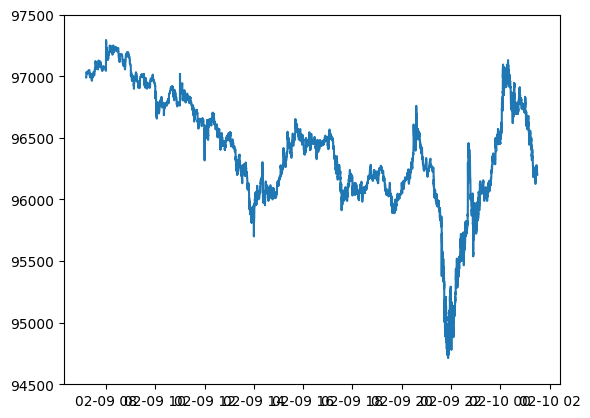

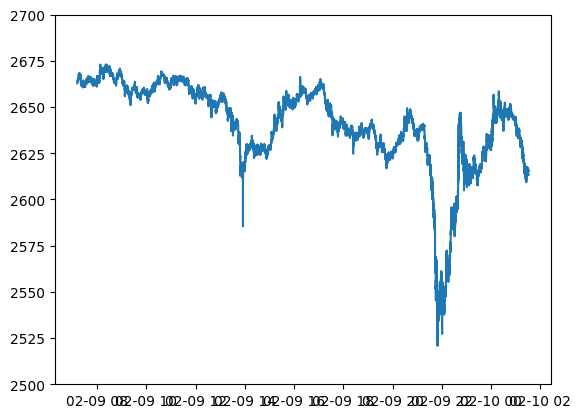

In [569]:
plt.plot(data['REFPRICE']['BTCUSDT'].rp * TICK_SIZES['BTCUSDT'])
plt.ylim(94500, 97500)
plt.show()
plt.plot(data['REFPRICE']['ETHUSDT'].rp * TICK_SIZES['ETHUSDT'])
plt.ylim(2500, 2700)
plt.show()

In [570]:
data['REFPRICE']['BTCUSDT']

,rp,trade
timestamp,,
2025-02-09 07:12:01.814,9698999.5,0
2025-02-09 07:12:01.914,9698999.5,0
2025-02-09 07:12:02.014,9698999.5,0
2025-02-09 07:12:02.067,9698999.5,1
2025-02-09 07:12:02.069,9698999.5,1
...,...,...
2025-02-10 01:29:51.014,9620000.5,0
2025-02-10 01:29:51.114,9620000.5,0
2025-02-10 01:29:51.214,9620000.5,0


In [571]:
# convert the depth prices into queue numbers
for crypto_pair in tqdm(CRYPTO_PAIRS):
    temp = data['DEPTH'][crypto_pair].copy(deep=True)
    temp['rp'] = data['REFPRICE'][crypto_pair].query('trade == 0').rp.to_numpy()
    data['DEPTH'][crypto_pair].loc[:, 'bp1':'bp10'] = data['DEPTH'][crypto_pair].loc[:, 'bp1':'bp10'].sub(temp.rp, axis=0) - 0.5
    data['DEPTH'][crypto_pair].loc[:, 'ap1':'ap10'] = data['DEPTH'][crypto_pair].loc[:, 'ap1':'ap10'].sub(temp.rp, axis=0) + 0.5
    data['DEPTH'][crypto_pair] = data['DEPTH'][crypto_pair].astype(int)

100%|██████████| 2/2 [00:00<00:00,  4.53it/s]


In [572]:
# convert the trade prices into queue numbers
for crypto_pair in tqdm(CRYPTO_PAIRS):
    temp = data['TRADE'][crypto_pair].copy(deep=True)
    temp['rp'] = data['REFPRICE'][crypto_pair].query('trade == 1').rp.to_numpy()
    temp_adj_factor = (data['TRADE'][crypto_pair].mm_buy * 2 - 1) * -0.5
    data['TRADE'][crypto_pair].p = temp.p - temp.rp + temp_adj_factor
    data['TRADE'][crypto_pair] = data['TRADE'][crypto_pair].astype(int)

100%|██████████| 2/2 [00:00<00:00,  9.54it/s]


In [444]:
data['DEPTH']['BTCUSDT']

,bp1,bp2,bp3,bp4,bp5,bp6,bp7,bp8,bp9,bp10,bv1,bv2,bv3,bv4,bv5,bv6,bv7,bv8,bv9,bv10,ap1,ap2,ap3,ap4,ap5,ap6,ap7,ap8,ap9,ap10,av1,av2,av3,av4,av5,av6,av7,av8,av9,av10
timestamp,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2025-02-09 07:12:01.814,9698999,9698998,9698997,9698996,9698991,9698990,9698981,9698980,9698979,9698978,1148072,18,18,18,29,5861,29,73024,12,12,9699000,9699030,9699043,9699046,9699047,9699066,9699076,9699084,9699133,9699134,2050288,28,18,29,18,18,18,18,24,1056
2025-02-09 07:12:01.914,9698999,9698998,9698997,9698996,9698991,9698990,9698981,9698980,9698979,9698978,1148072,18,18,18,29,5861,29,73024,12,12,9699000,9699030,9699043,9699046,9699047,9699066,9699076,9699084,9699133,9699134,2050288,28,18,29,18,18,18,18,24,1056
2025-02-09 07:12:02.014,9698999,9698998,9698997,9698996,9698991,9698990,9698981,9698980,9698979,9698978,1148072,18,18,18,29,5861,29,73024,12,12,9699000,9699030,9699043,9699046,9699047,9699066,9699076,9699084,9699133,9699134,2050288,28,18,29,18,18,18,18,24,1056
2025-02-09 07:12:02.114,9698999,9698998,9698997,9698996,9698991,9698990,9698981,9698980,9698979,9698978,1147977,18,18,18,29,5861,29,73024,12,12,9699000,9699030,9699043,9699046,9699047,9699066,9699076,9699084,9699133,9699134,2048261,28,18,29,18,18,18,18,24,1056
2025-02-09 07:12:02.214,9698999,9698998,9698997,9698996,9698991,9698990,9698981,9698980,9698979,9698978,1147893,18,18,18,29,5861,29,73024,12,12,9699000,9699030,9699043,9699046,9699047,9699066,9699076,9699084,9699133,9699134,2048272,28,18,18,18,18,18,18,24,1056
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-02-10 01:29:51.014,9620000,9619993,9619928,9619922,9619876,9619875,9619860,9619821,9619801,9619800,1035129,36,28,25,18,18,18,28,24,7151,9620001,9620035,9620036,9620037,9620038,9620056,9620079,9620112,9620115,9620153,621713,18,24374,7359,6,6,12,772,6144,6
2025-02-10 01:29:51.114,9620000,9619993,9619928,9619922,9619876,9619875,9619860,9619821,9619801,9619800,1035129,36,28,25,18,18,18,28,24,7151,9620001,9620035,9620036,9620037,9620038,9620056,9620079,9620112,9620115,9620153,621720,18,24374,7359,6,6,12,772,6144,6
2025-02-10 01:29:51.214,9620000,9619993,9619928,9619922,9619876,9619875,9619860,9619821,9619801,9619800,1035129,36,28,25,18,18,18,28,24,7151,9620001,9620035,9620036,9620037,9620038,9620056,9620079,9620112,9620115,9620153,621720,18,24374,7359,6,6,12,760,6083,6


In [445]:
data['TRADE']['BTCUSDT']

,p,q,mm_buy
timestamp,,,
2025-02-09 07:12:02.067,9699000,14,0
2025-02-09 07:12:02.069,9699000,1999,0
2025-02-09 07:12:02.071,9698999,96,1
2025-02-09 07:12:02.464,9699000,1374,0
2025-02-09 07:12:03.252,9699000,289,0
...,...,...,...
2025-02-10 01:29:48.730,9620001,1642,0
2025-02-10 01:29:49.639,9620000,28,1
2025-02-10 01:29:49.970,9620001,6,0


In [446]:
data['DEPTH']['ETHUSDT'].loc['2025-02-09 13:17:41':'2025-02-09 13:17:43']

,bp1,bp2,bp3,bp4,bp5,bp6,bp7,bp8,bp9,bp10,bv1,bv2,bv3,bv4,bv5,bv6,bv7,bv8,bv9,bv10,ap1,ap2,ap3,ap4,ap5,ap6,ap7,ap8,ap9,ap10,av1,av2,av3,av4,av5,av6,av7,av8,av9,av10
timestamp,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2025-02-09 13:17:41.015,264849,264848,264847,264845,264844,264841,264840,264836,264832,264828,975952,161546,30,51,50,22,8829,47,25080,12376,264850,264851,264852,264853,264854,264858,264859,264860,264862,264867,797,80,520,20,40,60,1046,20,57,38
2025-02-09 13:17:41.115,264849,264848,264847,264845,264844,264841,264840,264836,264832,264828,1051341,161546,30,51,50,22,8829,47,25080,12376,264850,264851,264852,264853,264854,264858,264859,264860,264862,264867,797,80,520,20,40,60,1046,20,57,38
2025-02-09 13:17:41.215,264849,264848,264847,264845,264844,264841,264840,264836,264832,264828,1053149,161546,30,51,50,22,8829,47,25080,12356,264850,264851,264852,264853,264854,264858,264859,264860,264862,264867,748,80,520,20,40,60,1046,20,38,57
2025-02-09 13:17:41.315,264849,264848,264847,264845,264844,264841,264840,264836,264832,264828,1047788,161546,30,51,50,22,8829,47,25080,12356,264850,264851,264852,264853,264854,264858,264859,264860,264862,264867,748,80,520,20,40,60,1046,20,38,57
2025-02-09 13:17:41.415,264849,264848,264847,264845,264844,264841,264840,264836,264832,264828,1047788,161546,30,51,50,22,8829,47,42176,12356,264850,264851,264852,264853,264854,264858,264859,264860,264862,264867,748,80,520,20,40,60,1046,20,38,57
2025-02-09 13:17:41.515,264849,264848,264847,264845,264844,264841,264840,264836,264832,264828,1046547,161546,30,51,50,22,8829,47,25080,12356,264850,264851,264852,264853,264854,264858,264859,264860,264862,264867,748,80,520,20,40,60,1046,20,38,57
2025-02-09 13:17:41.615,264849,264848,264847,264845,264844,264841,264840,264836,264832,264828,1046598,161546,30,51,50,22,8829,47,25080,12356,264850,264851,264852,264853,264854,264858,264859,264860,264862,264867,799,80,520,20,40,60,1046,20,38,57
2025-02-09 13:17:41.715,264849,264848,264847,264845,264844,264841,264840,264836,264832,264828,1046598,161546,30,51,50,22,8829,47,25080,12356,264850,264851,264852,264853,264854,264858,264859,264860,264862,264867,799,80,520,20,40,60,1046,20,38,57
2025-02-09 13:17:41.815,264849,264848,264847,264845,264844,264841,264840,264836,264832,264828,1046426,161546,30,51,50,22,8829,47,25080,12356,264850,264851,264852,264853,264854,264858,264859,264860,264862,264867,705,80,520,20,40,60,1046,20,38,57


In [447]:
data['TRADE']['ETHUSDT'].loc['2025-02-09 13:17:41'].head(100)

,p,q,mm_buy
timestamp,,,
2025-02-09 13:17:41.164,264849,22,1
2025-02-09 13:17:41.290,264849,5360,1
2025-02-09 13:17:41.450,264849,417,1
2025-02-09 13:17:41.450,264849,822,1
2025-02-09 13:17:41.775,264850,20,0
2025-02-09 13:17:41.775,264850,30,0
2025-02-09 13:17:41.775,264850,30,0
2025-02-09 13:17:41.775,264850,30,0
2025-02-09 13:17:41.775,264850,30,0


In [432]:
pd.to_datetime('2025-02-09 13:17:41.915')

Timestamp('2025-02-09 13:17:41.915000')

In [448]:
best_prices['ETHUSDT'].loc['2025-02-09 13:17:41'].head(100)

,bp1,ap1,trade
timestamp,,,
2025-02-09 13:17:41.015,264849,264850,0
2025-02-09 13:17:41.115,264849,264850,0
2025-02-09 13:17:41.164,264849,264850,1
2025-02-09 13:17:41.215,264849,264850,0
2025-02-09 13:17:41.290,264849,264850,1
2025-02-09 13:17:41.315,264849,264850,0
2025-02-09 13:17:41.415,264849,264850,0
2025-02-09 13:17:41.450,264849,264850,1
2025-02-09 13:17:41.450,264849,264850,1


In [409]:
temp.loc['2025-02-09 13:17:41'].head(100)

,p,q,mm_buy,rp
timestamp,,,,
2025-02-09 13:17:41.164,264849,22,1,264849.5
2025-02-09 13:17:41.290,264849,5360,1,264849.5
2025-02-09 13:17:41.450,264849,417,1,264849.5
2025-02-09 13:17:41.450,264849,822,1,264849.5
2025-02-09 13:17:41.775,264850,20,0,264849.5
2025-02-09 13:17:41.775,264850,30,0,264849.5
2025-02-09 13:17:41.775,264850,30,0,264849.5
2025-02-09 13:17:41.775,264850,30,0,264849.5
2025-02-09 13:17:41.775,264850,30,0,264849.5


In [574]:
data['TRADE']['ETHUSDT'].query('p == 0 & mm_buy == 1')

,p,q,mm_buy
timestamp,,,
2025-02-09 13:17:41.921,0,52912,1
2025-02-09 13:17:41.921,0,5997,1
2025-02-09 13:17:41.921,0,3775,1
2025-02-09 13:17:41.921,0,57286,1
2025-02-09 13:17:41.921,0,30,1
...,...,...,...
2025-02-10 01:16:40.320,0,30,1
2025-02-10 01:16:40.320,0,20,1
2025-02-10 01:16:40.320,0,30,1
